# Stellar Classification using Photometric data

In [37]:
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.model_selection import cross_val_score, cross_validate, train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.compose import make_column_transformer
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# Summary

# Results and Discussion

First of all, let's import the packages we will use to carry out the analysis.

In astronomy, it is useful to classify stars based on certain characteristics. In the earliest days it was based on mass and temperature; however, our modern classification system has evolved and we classify stars based on the *Morgan–Keenan (MK)* system which group stars into 7 classes based on their spectral characteristics. Under the MK system, astronomers analyse electromagnetic radiation from stars to determine its class. These electromagnetic spectrum have dark lines to determine which and how abundant elements are present in the star. The 7 classes in the MK system - *O, B, A, F, G, K*, and *M* - are sequenced from the hottest (*O* type) to the coolest (*K* type) which also exhibits a certain characteristic that is very visible - colour. Hence in this report, we will classify stars using photometric data and in the Discussion section, we will evaluate whether this is a reliable alternative for the traditional method.

## Definitions

**Photometry**: the measurement of the flux or intensity of an astronomical object's electromagnetic radiation

The photometric system we're using to classify star types is the *Sloan* system (add reference) used by the Sloan Digital Sky Survey. The system measures the intensity of electromagnetic radition from stars at 5 bands:
- *u* (345nm)
- *g* (475nm which is a light blue in the visible spectrum)
- *r* (622nm which is orange)
- *i* (763nm which is deep red)
- *z* (905nm)

NASA Exoplanet Archive collects data from various sources, including ground-based observatories and space telescopes such as the Kepler Space Telescope and the Transiting Exoplanet Survey Satellite (TESS). The dataset is we're using is their [Planetary Systems dataset](https://exoplanetarchive.ipac.caltech.edu/cgi-bin/TblView/nph-tblView?app=ExoTbls&config=PS) which has the columns of names, spectral type and measurements using Sloan photometric system selected.

In [5]:
import pandas as pd
import requests
import os
from datetime import datetime

We then download the dataset of interest; the Expoplanet Systems dataset from NASA, containing information about measurements of planets and stars. We are interested in the spectral type of stars given a subset of these measurements.

In [43]:
current_date = datetime.now().date().strftime("%Y-%m-%d")

raw_data_dir = os.path.join("data", "raw")
raw_data_path = os.path.join(raw_data_dir, f"{current_date}_planet-systems.csv")

# make directory where we store our raw data
os.makedirs(raw_data_dir, exist_ok=True)

# check if we already have the dataset downloaded
if len(os.listdir(raw_data_dir)) != 0:
    print(len(os.listdir(raw_data_dir)))
    print(f"Using already existing dataset under {raw_data_dir}")
else:
    # download the raw data as CSV under the raw data directory
    url = "https://exoplanetarchive.ipac.caltech.edu/cgi-bin/IceTable/nph-iceTblDownload"
    print(f"Downloading Planet Systems dataset from {url}")

    # define an HTTP request
    payload = {
        "workspace": "2024.02.29_21.58.35_020450/TblView/2024.03.02_14.52.28_004142",
        "useTimestamp": "1",
        "table": "/exodata/kvmexoweb/ExoTables/PS.tbl",
        "format": "CSV",
        "user": "",
        "label": "*",
        "columns": "pl_name_display,st_spectype,sy_umagstr,sy_gmagstr,sy_rmagstr,sy_imagstr,sy_zmagstr",
        "rows": "both",
        "mission": "ExoplanetArchive"
    }
    response = requests.get(url, params=payload)

    # assume request was successfull and access the downloaded content    
    raw_data = response.content

    # write downloaded content into a file under the raw data directory
    with open(raw_data_path, "wb") as f:
        f.write(raw_data)

# df holds the expolanet dataset as a DataFrame object
df = pd.read_csv(
    raw_data_path,
    header = 23, # 24-1=23
    dtype = {'pl_name' : 'string', 'st_spectype' : 'string'}
)

# remove columns in the dataset that have 'err' in their name
filtered_columns = [col for col in df.columns if 'err' not in col]

df = df[filtered_columns]

df

,pl_name,st_spectype,sy_umag,sy_gmag,sy_rmag,sy_imag,sy_zmag
0,11 Com b,<NA>,NaN,NaN,NaN,NaN,NaN
1,11 Com b,G8 III,NaN,NaN,NaN,NaN,NaN
2,11 Com b,G8 III,NaN,NaN,NaN,NaN,NaN
3,11 UMi b,<NA>,NaN,NaN,NaN,NaN,NaN
4,11 UMi b,<NA>,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...
35843,ups And d,<NA>,NaN,NaN,NaN,NaN,NaN
35844,ups Leo b,G9 III,NaN,NaN,NaN,NaN,NaN
35845,xi Aql b,<NA>,NaN,NaN,NaN,NaN,NaN
35846,xi Aql b,<NA>,NaN,NaN,NaN,NaN,NaN


This dataset from NASA's Exoplanet Archive include all planets and stars. Therefore we will wrangle the dataset such that it only contain stars with Sloan magnitudes for photometric measurements.

Variables:

st_spectype: Classification of the star based on their spectral characteristics following the Morgan-Keenan system

sy_umag: Brightness of the host star as measured using the Sloan Digital Sky Survey (SDSS) u band, in units of magnitudes

sy_gmag: Brightness of the host star as measured using the Sloan Digital Sky Survey (SDSS) g band, in units of magnitudes

sy_rmag: Brightness of the host star as measured using the Sloan Digital Sky Survey (SDSS) r band, in units of magnitudes

sy_imag: Brightness of the host star as measured using the Sloan Digital Sky Survey (SDSS) i band, in units of magnitudes

sy_zmag: Brightness of the host star as measured using the Sloan Digital Sky Survey (SDSS) z band, in units of magnitudes

In [39]:
# pre-process data
only_stars_data = exoplanet_data.dropna(subset = ['st_spectype',
                                                  'sy_umag',
                                                  'sy_gmag',
                                                  'sy_rmag',
                                                  'sy_imag',
                                                  'sy_zmag'])
only_stars_data.info

<bound method DataFrame.info of             pl_name st_spectype  sy_umag  sy_gmag    sy_rmag   sy_imag  \
180    BD+20 2457 b       K2 II  14.9129  10.5155   9.277390   8.84049   
182    BD+20 2457 c       K2 II  14.9129  10.5155   9.277390   8.84049   
183     BD+20 274 b      K5 III  14.3374  10.1863   8.941711   8.49228   
210      BD-17 63 b        K5 V  14.1468  10.2994   9.211040   8.86964   
215        CD Cet b      M5.0 V  17.4608  15.0603  13.949400  14.18480   
...             ...         ...      ...      ...        ...       ...   
35641        XO-1 b        G1 V  14.8365  11.7844  11.049500  10.86850   
35701        XO-5 b        G8 V  15.3529  15.0080  11.988900  11.82070   
35702        XO-5 b        G8 V  15.3529  15.0080  11.988900  11.82070   
35703        XO-5 b        G8 V  15.3529  15.0080  11.988900  11.82070   
35704        XO-5 b        G8 V  15.3529  15.0080  11.988900  11.82070   

        sy_zmag  
180     8.97784  
182     8.97784  
183     8.90440  
210    

In [40]:
only_stars_data = df.dropna(
    subset = [
        'st_spectype',
        'sy_umag',
        'sy_gmag',
        'sy_rmag',
        'sy_imag',
        'sy_zmag'
    ]
)

# we are only interested in the first letter of spectral type, which becomes our y later
only_stars_data_copy = only_stars_data.copy() # needed to avoid warning raised by pandas
only_stars_data_copy["st_spectype"] = only_stars_data_copy['st_spectype'].transform(lambda x: x[0])
only_stars_data = only_stars_data_copy

only_stars_data

/var/folders/4m/5p4jml4167j8v0s3f5sxvllm0000gn/T/ipykernel_82975/4216926385.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  only_stars_data["st_spectype"] = only_stars_data['st_spectype'].transform(lambda x: x[0])


,pl_name,st_spectype,sy_umag,sy_gmag,sy_rmag,sy_imag,sy_zmag
180,BD+20 2457 b,K,14.9129,10.5155,9.277390,8.84049,8.97784
182,BD+20 2457 c,K,14.9129,10.5155,9.277390,8.84049,8.97784
183,BD+20 274 b,K,14.3374,10.1863,8.941711,8.49228,8.90440
210,BD-17 63 b,K,14.1468,10.2994,9.211040,8.86964,9.00956
215,CD Cet b,M,17.4608,15.0603,13.949400,14.18480,13.29560
...,...,...,...,...,...,...,...
35641,XO-1 b,G,14.8365,11.7844,11.049500,10.86850,11.31440
35701,XO-5 b,G,15.3529,15.0080,11.988900,11.82070,13.65610
35702,XO-5 b,G,15.3529,15.0080,11.988900,11.82070,13.65610
35703,XO-5 b,G,15.3529,15.0080,11.988900,11.82070,13.65610


In [41]:
only_stars_data.describe(include="all")

,pl_name,st_spectype,sy_umag,sy_gmag,sy_rmag,sy_imag,sy_zmag
count,371,371,371.000000,371.000000,371.000000,371.000000,371.000000
unique,220,6,NaN,NaN,NaN,NaN,NaN
top,K2-3 d,M,NaN,NaN,NaN,NaN,NaN
freq,5,121,NaN,NaN,NaN,NaN,NaN
mean,NaN,NaN,16.052537,13.850186,12.706372,12.396249,12.437584
std,NaN,NaN,1.558657,1.846257,1.743469,1.726103,1.457525
min,NaN,NaN,13.093200,9.912880,8.463130,7.750550,7.763190
25%,NaN,NaN,15.098200,12.489000,11.674600,11.389700,11.905000
50%,NaN,NaN,15.550900,13.770300,12.570600,12.151500,12.839400
75%,NaN,NaN,16.504950,15.231100,13.725700,13.481150,13.303600


In [42]:
# We will be trying to predict what st_spectype a star has
y = only_stars_data["st_spectype"]

# Our predictors will be the following 5 features
X = only_stars_data[["sy_umag", "sy_gmag", "sy_rmag", "sy_imag", "sy_zmag"]]

# Creating a 75% train test split to run on our data
X_train, X_test, y_train, y_test = train_test_split(X, 
                                                    y, 
                                                    test_size=0.3, 
                                                    random_state=123)


In [43]:
y_train.value_counts(normalize=True)

st_spectype
G    0.305019
M    0.297297
K    0.297297
F    0.092664
W    0.007722
Name: proportion, dtype: float64

We have a pretty spread out class with no major calss imbalance.

In [44]:
# Pre-process the data
star_preprocessor = make_column_transformer(
    (StandardScaler(), X)
)

In [45]:
# Logistic Regression
pipe = make_pipeline(StandardScaler(), LogisticRegression())
pd.DataFrame(cross_validate(pipe, X_train, y_train, return_train_score=True)).mean()

/Users/lucyliu/miniconda3/envs/dsci-310-group16/lib/python3.12/site-packages/sklearn/model_selection/_split.py:737: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=5.
  warnings.warn(


fit_time       0.009352
score_time     0.001120
test_score     0.663952
train_score    0.693046
dtype: float64

## Confusion Matrix
One way to get a better understanding of the errors is by looking at 
- How well the classifier is identifying each class.
- Which classes are most frequently confused with each other.
- Overall accuracy, along with class-specific metrics like precision, recall, and F1-score for multi-class classification problems.


It's easier to demonstrate evaluation metrics using an explicit validation set instead of using cross-validation. So let's create a validation set. 

In [46]:
X_train_2, X_valid, y_train_2, y_valid = train_test_split(
    X_train, y_train, test_size=0.3, random_state=123
)

In [47]:
from sklearn.metrics import confusion_matrix

# Train the model on the training set
pipe.fit(X_train, y_train)

# Predict y values for the validation set
predictions = pipe.predict(X_valid)

# Compare the predicted y values with actual y values of the validaiton set using the confusion matrix
cm = confusion_matrix(y_valid, predictions)
print(cm)

[[ 0  8  0  0  0]
 [ 0 19  3  0  0]
 [ 0  5 18  2  0]
 [ 0  0  1 21  0]
 [ 0  0  0  0  1]]


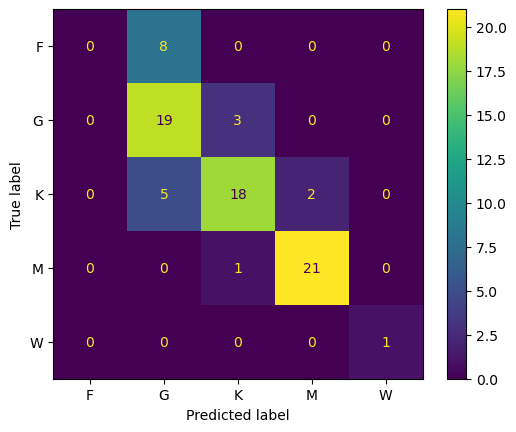

In [48]:
#For better interpretation, we will visualize the confusion matrix using 'ConfusionMatrixDisplay'
ConfusionMatrixDisplay.from_predictions(y_valid, predictions)

plt.show()

In [49]:
# we will try one more classifier, RandomForest Classifier
rfc = RandomForestClassifier(n_estimators=275, random_state=123)

# Calculate mean cross_val_score score of test scores
cv_results = cross_val_score(rfc, X, y, cv=5, scoring='accuracy')
print("Mean cross validation score:", cv_results.mean())

# We are fitting our classifier to our dataset
rfc.fit(X_train, y_train)

# Calculating the accuracy of our predictions made on the test set
predictions = rfc.predict(X_test)
accuracy = accuracy_score(y_test, predictions)
print("Accuracy:", accuracy)

/Users/lucyliu/miniconda3/envs/dsci-310-group16/lib/python3.12/site-packages/sklearn/model_selection/_split.py:737: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(


Mean cross validation score: 0.6551351351351351
Accuracy: 0.8928571428571429
